# Step Length Distribution Analysis

Run simulations on different agent types and record their step lengths. 
Then analyse whether any of them follow power law distribution. 

Note:
The step lengths are recorded as agent attributes and accessed via the population directly.
That is why only a single iteration is done. Compensate this by using more agents or increasing the simulation time.

In [2]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
from simulation import Simulation
import matplotlib.pyplot as plt
from agent import ReservoirAgent, LévyAgent, ExponentialAgent
from environment import Environment
import powerlaw
from tqdm.notebook import tqdm
from config import DATA_PATH
from pathlib import Path
import pickle

tolerance = 0.001

params = Params.from_json('parameters.json')
params.save = False
params.iterations = 1
data = []
environment = Environment(params)
folder = 'step_lengths'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)

# Reservoir Agent Step Length Sampling

In [3]:
data = []
params.type = 'reservoir'
params.agent = ReservoirAgent

sigma_range = [0.032, 0.04, 0.05]
repeats = 5

for sigma in tqdm(sigma_range, position=0):
    params.standard_deviation = sigma
    sim = Simulation(params, params.agent)

    step_lengths_total = []
    for repeat in tqdm(range(repeats), position=1, leave=False):
        if repeat != 0:
            # reinitialize the reservoir
            for agent in population:
                agent.model.burn_in_state_matrix = agent.model.burn_in()
                agent.model.run()
        population = sim.run_iteration(sim.set_up_population(None), environment)
        step_lengths = []
        for agent in population:
            step_counter = 1
            for output in agent.output_log:
                if abs(output) > 1 - tolerance or abs(output) < tolerance:
                    step_counter += 1
                else:
                    step_lengths.append(step_counter)
                    step_counter = 1
            step_lengths.append(step_counter)
        step_lengths_total.extend(step_lengths)
    data.append(step_lengths_total)

with open(path / 'data.pkl', 'wb') as f:
    pickle.dump(data, f)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Log-log Plots

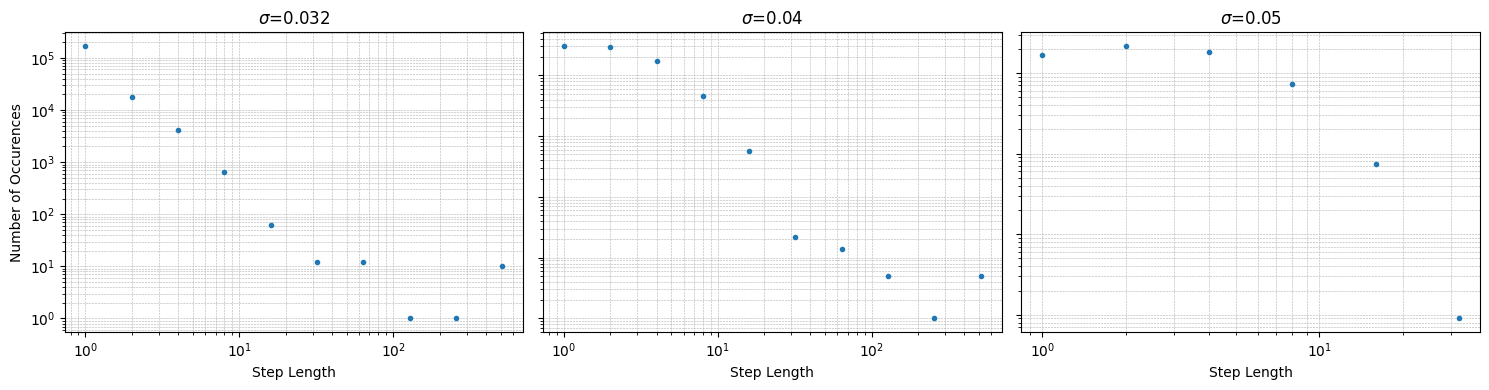

In [19]:
with open(path / 'data.pkl', 'rb') as f:
    data = pickle.load(f)

n = len(sigma_range)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, sigma in enumerate(sigma_range):
    ax = axes[i]
    counts, bins = np.histogram(data[i], bins=[2**i for i in range(int(max(data[i])).bit_length() + 1)])
    ax.loglog(bins[:-1], counts, marker='.', linestyle='none')
    ax.set_title(r'$\sigma$=' + str(round(sigma, 3)))
    ax.set_xlabel('Step Length')
    if i == 0:
        ax.set_ylabel('Number of Occurences')
    else:
        ax.set_yticklabels([])
    
# turn off additional axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# grid lines
for ax in axes:
    ax.grid(True, which="both", ls="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(path / 'log-log_step_lengths_reservoir_separate.svg', format='svg')

# Lévy Agent Step Length Sampling

In [5]:
params.type = 'levy'
params.agent = LévyAgent
sim = Simulation(params, params.agent)
population = sim.run_iteration(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Exponential Agent Step Length Sampling

In [6]:
params.type = 'exponential'
params.agent = ExponentialAgent
sim = Simulation(params, params.agent)
population = sim.run_iteration(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Log-log Plot Comparison of Agents

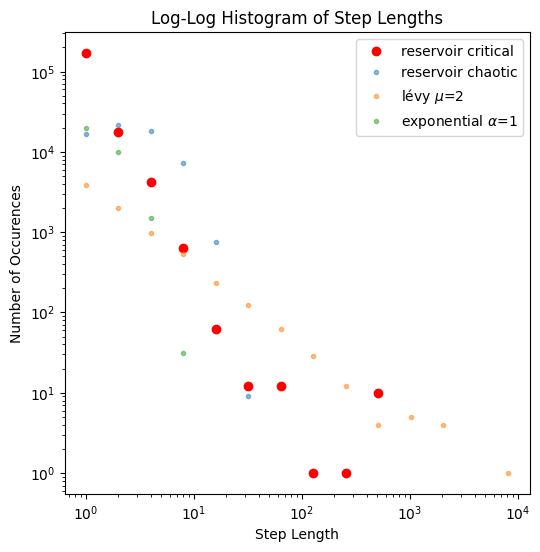

In [7]:
plt.figure(figsize = (6, 6))

labels = ['reservoir critical', 'skip', 'reservoir chaotic', r'lévy $\mu$=' + str(params.mu), r'exponential $\alpha$=' + str(params.alpha)]
colors = ['red', None, None, None, None]

for i in range(len(data)):
    if i == 1:
        continue
    opacity = 1 if i == 0 else 0.5
    marker = 'o' if i == 0 else '.'
    counts, bins = np.histogram(data[i], bins=[2**i for i in range(int(max(data[i])).bit_length() + 1)])
    plt.loglog(bins[:-1], counts, marker=marker, linestyle='none', label=labels[i], alpha=opacity, color=colors[i])

plt.xlabel('Step Length')
plt.ylabel('Number of Occurences')
plt.legend()
plt.title('Log-Log Histogram of Step Lengths')
plt.savefig(path / 'log-log_step_lengths.svg', format='svg')

# Critical Reservoir Agents $\mu$

In [8]:
assert(min(data[0]) == 1)
fit_critical_reservoir = powerlaw.Fit(data[0], xmin=1, discrete=True)
print(f"alpha: {fit_critical_reservoir.alpha:.2f}")

alpha: 2.23


# Sanity Check Data with Additional Figures
### Regular Histograms of First Step Lengths

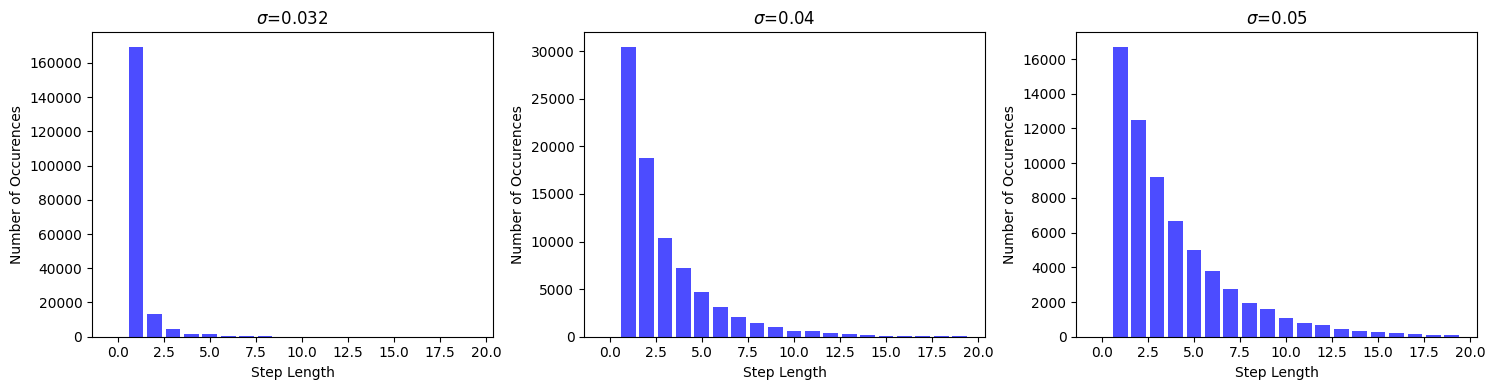

In [9]:
with open(path / 'data.pkl', 'rb') as f:
    data = pickle.load(f)

limit = 20

n = len(sigma_range)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, sigma in enumerate(sigma_range):
    ax = axes[i]
    counts = np.bincount(data[i])
    ax.bar(range(min(limit, len(counts))), counts[:min(limit, len(counts))], color='blue', alpha=0.7)
    ax.set_title(r'$\sigma$=' + str(round(sigma, 3)))
    ax.set_xlabel('Step Length')
    ax.set_ylabel('Number of Occurences')

# turn off additional axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(path / 'histogram_step_lengths_reservoir_separate.svg', format='svg')

### Binned Capped Histogram of First $\sigma$

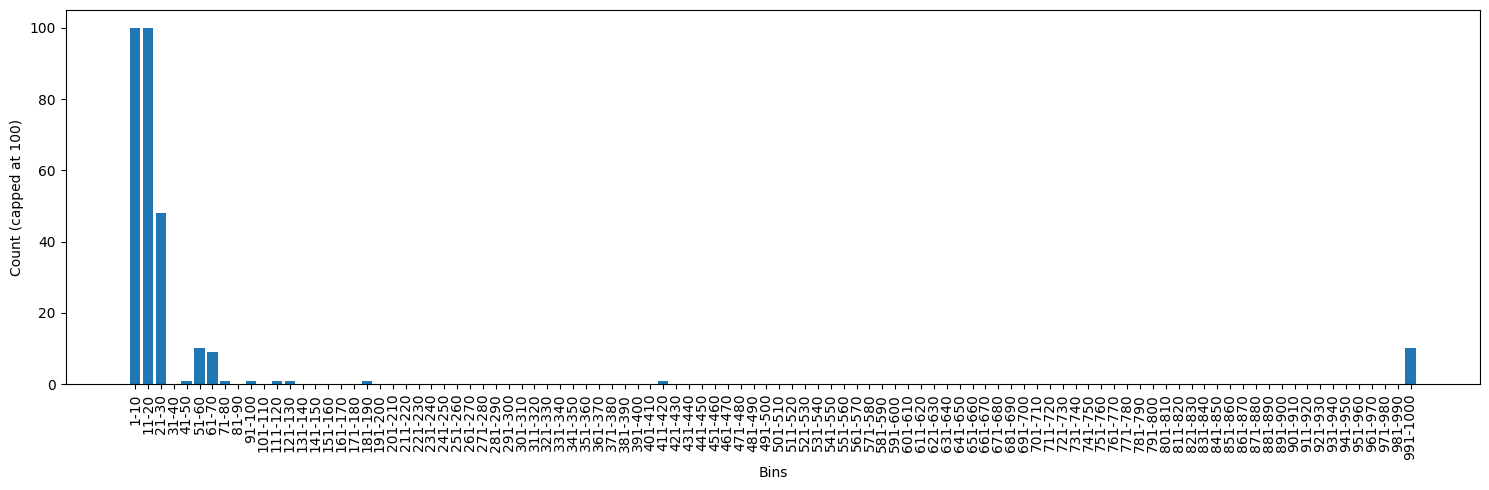

In [10]:
bin_size = 10
counts, bins = np.histogram(data[0], bins=range(min(data[0]), max(data[0]) + bin_size, bin_size))
counts = np.minimum(counts, 100)
bin_labels = [f"{b}-{b+bin_size-1}" for b in bins[:-1]]

plt.figure(figsize=(15, 5))
plt.bar(bin_labels, counts)
plt.xticks(rotation=90)
plt.xlabel("Bins")
plt.ylabel("Count (capped at 100)")
plt.tight_layout()
plt.show()

### Log-log Plots of Exponential Agent

In [11]:
data = []
params.type = 'exponential'
params.agent = ExponentialAgent

alpha_range = np.arange(1, 4, 1)

for alpha in tqdm(alpha_range):
    sim = Simulation(params, params.agent)
    population = sim.run_iteration(sim.set_up_population(None), environment)
    step_lengths = np.array([])
    for agent in population:
        step_lengths = np.concatenate((step_lengths, agent.step_length_log))
    data.append(step_lengths)

  0%|          | 0/3 [00:00<?, ?it/s]

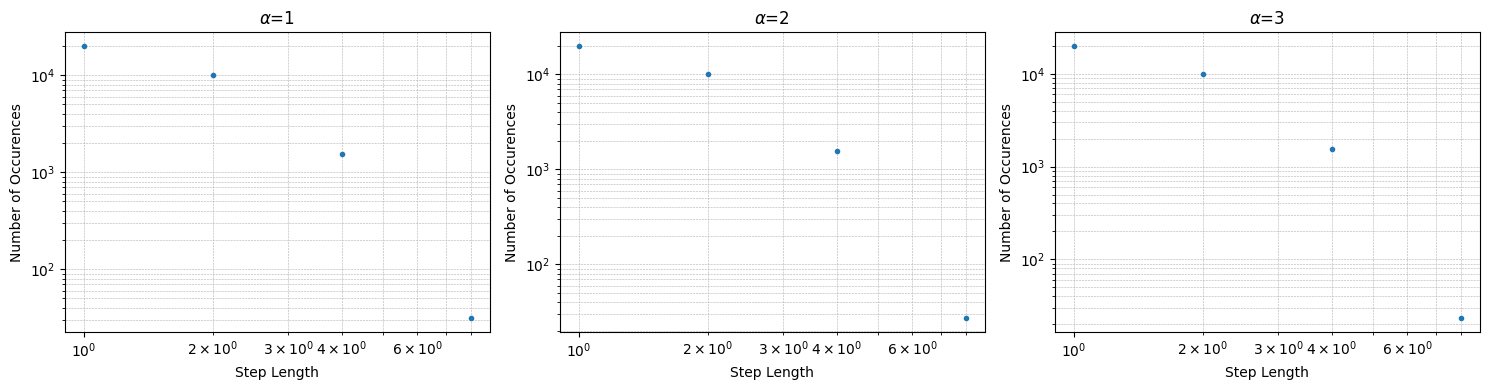

In [12]:
n = len(alpha_range)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, alpha in enumerate(alpha_range):
    ax = axes[i]
    counts, bins = np.histogram(data[i], bins=[2**i for i in range(int(max(data[i])).bit_length() + 1)])
    ax.loglog(bins[:-1], counts, marker='.', linestyle='none')
    ax.set_title(r'$\alpha$=' + str(round(alpha, 3)))
    ax.set_xlabel('Step Length')
    ax.set_ylabel('Number of Occurences')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

# grid lines
for ax in axes:
    ax.grid(True, which="both", ls="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(path / 'log-log_step_lengths_exponential_separate.svg', format='svg')

### Log-log Plots of Lévy Agent

In [13]:
data = []
params.type = 'levy'
params.agent = LévyAgent

mu_range = [1.01, 2, 3]

for mu in tqdm(mu_range):
    sim = Simulation(params, params.agent)
    population = sim.run_iteration(sim.set_up_population(None), environment)
    step_lengths = np.array([])
    for agent in population:
        step_lengths = np.concatenate((step_lengths, agent.step_length_log))
    data.append(step_lengths)

  0%|          | 0/3 [00:00<?, ?it/s]

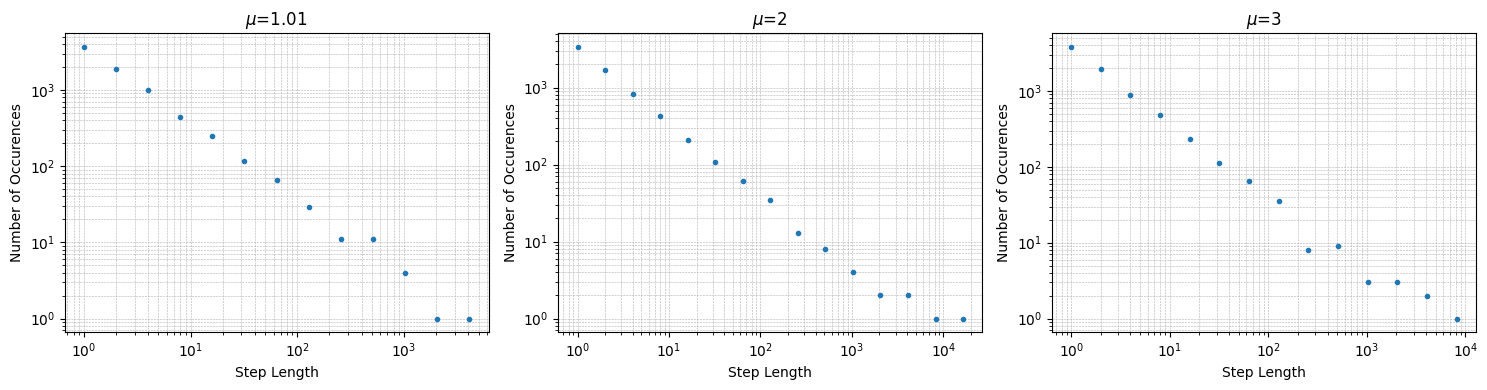

In [14]:
n = len(mu_range)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, mu in enumerate(mu_range):
    ax = axes[i]
    counts, bins = np.histogram(data[i], bins=[2**i for i in range(int(max(data[i])).bit_length() + 1)])
    ax.loglog(bins[:-1], counts, marker='.', linestyle='none')
    ax.set_title(r'$\mu$=' + str(round(mu, 3)))
    ax.set_xlabel('Step Length')
    ax.set_ylabel('Number of Occurences')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

# grid lines
for ax in axes:
    ax.grid(True, which="both", ls="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(path / 'log-log_step_lengths_levy_separate.svg', format='svg')